In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from keras.datasets import mnist
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from keras.optimizers import SGD, Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook
from sklearn.utils import shuffle

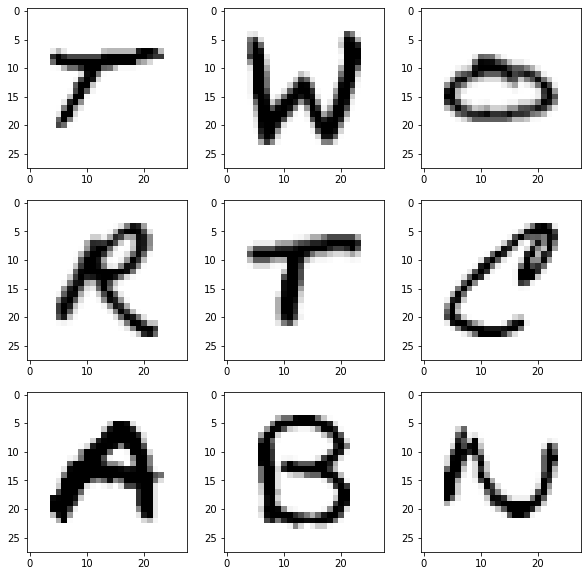

In [28]:
# populate list Data with the CSV
data = pd.read_csv("../data/A_Z Handwritten Data.csv").astype('float32')

# Split data the X - Our data , and y - the prdict label
X = data.drop('0', axis = 1)
y = data['0']

#Split the data into training and test subsets
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.2)

#Turns the 784 columns of grayscale pixel data into 28X28 array of data
train_X = np.reshape(train_X.values, (train_X.shape[0], 28, 28))
test_X = np.reshape(test_X.values, (test_X.shape[0], 28, 28))

shuff = shuffle(train_X[:100])
fig, ax = plt.subplots(3,3, figsize = (10,10))
axes = ax.flatten()
for i in range(9):
    _, shu = cv2.threshold(shuff[i], 30, 200, cv2.THRESH_BINARY)
    axes[i].imshow(np.reshape(shuff[i], (28,28)), cmap="Greys")
plt.show()

train_X = train_X.reshape(train_X.shape[0],train_X.shape[1],train_X.shape[2],1)
test_X = test_X.reshape(test_X.shape[0], test_X.shape[1], test_X.shape[2],1)

train_y = to_categorical(train_y, num_classes = 26, dtype='int')
test_y = to_categorical(test_y, num_classes = 26, dtype='int')

In [27]:
print(train_X.shape)
print(y.head)

word_dict = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M',
             13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y',
             25: 'Z'}

(297960, 28, 28, 1)
<bound method NDFrame.head of 0          0.0
1          0.0
2          0.0
3          0.0
4          0.0
          ... 
372445    25.0
372446    25.0
372447    25.0
372448    25.0
372449    25.0
Name: 0, Length: 372450, dtype: float32>


In [41]:
model = Sequential()

model.add(Conv2D(filters = 64, kernel_size = 3, activation = 'relu', input_shape = (28, 28, 1)))
model.add(MaxPool2D(pool_size = 2))

model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(26, activation = 'relu'))

model.compile(optimizer = Adam(), loss = 'categorical_crossentropy', metrics = ['accuracy'])

early_stopping = EarlyStopping(
    min_delta=0.001,
    patience=20,
    restore_best_weights=True,
)

In [ ]:
history = model.fit(train_X, train_y, validation_data = (test_X, test_y), batch_size = 128, epochs = 200, callbacks = [early_stopping])

Epoch 1/200
2181/2328 [===========================>..] - ETA: 4s - loss: nan - accuracy: 0.1386        